This notebook can be used to generate and visualize the final results for the paper. 

In [1]:
# Import libraries
import neptune.new as neptune
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import os

In [15]:
def plot(x, y, color, label, xlabel='Epoch', ylabel='Loss', title='Training loss'):
    plt.plot(x,y, '-', color=color, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    
    
def plot_train_val(metric, plot_title):
    figure(figsize=(6, 5), dpi=80)
    train_loss = run["training/train_"+metric].fetch_values()
    val_loss = run["training/val_"+metric].fetch_values()
    plot(train_loss.step, train_loss.value, color='blue', label='training')
    plot(val_loss.step, val_loss.value, color='orange', label='validation', title=plot_title)
    plt.ylabel(metric)
    plt.legend()
    plt.show()
    

def compare_two_runs(master, x, y, x_label, y_label):
    plt.figure(figsize=(5,5))
    xmax = (master[x].epoch.values.max() if master[x].epoch.values.max() > master[y].epoch.values.max() else master[y].epoch.values.max())


    plot(master[x].epoch.values, master[x].train_auroc.values, color='blue', label=x_label)
    plot(master[x].epoch.values, master[x].val_auroc.values, color='lightblue', label=x_label)

    plot(master[y].epoch.values, master[y].train_auroc.values, color='red', label=y_label)
    plot(master[y].epoch.values, master[y].val_auroc.values, color='coral', label=y_label)

    plt.ylabel('AUROC')
    plt.xlabel('Epoch')
    plt.title('AUROC')
    plt.xlim([-0.5,xmax])
    plt.legend()
    
    
    
def runs_results(task, lr, epochs, bs, runs):
    # Open their results dataframes and add to dictionary
    save_dir = '/scratch/fs999/shamoutlab/Farah/contrastive-learning-results/checkpoints/{}/models'.format(task)
    master={}
    best_results = {}
    for r in runs:
        file_name = r + '-select-LC'+'-lr{}-e{}-bs{}'.format(lr, epochs, bs)
        results_path = save_dir+'/'+file_name+'/'
        results_file_path = results_path+'results.csv'  
        run_results = pd.read_csv(results_file_path)
        col_delete=[x for x in list(run_results) if "Unnamed" in x]
        run_results = run_results.drop(columns=col_delete)

        master[r]= run_results
        best_results[r] = run_results.loc[run_results['val_auroc'].idxmax()].to_dict()

    best_results = pd.DataFrame.from_dict(best_results, orient='index').reset_index().rename(columns={'index':'run'})
    return best_results

In [16]:
## Specify names of best runs
runs = ['SIMCLR-1041613']

In [17]:
## Table 1: Dataset summary can be obtained from the logs of the runs above

In [26]:
## Table 2: Evaluation on downstream tasks

# Provide linear evaluation settings
lr = 0.01
bs = 512
epochs = 100 

task = 'phenotyping'
best_results_pheno = runs_results(task, lr, epochs, bs, runs)
print(task)
print(best_results_pheno.to_string())

task = 'mortality'
best_results_mort = runs_results(task, lr, epochs, bs, runs)
print('\n'+task)
print(best_results_mort.to_string())


phenotyping
              run  epoch  train_auroc  train_auprc  val_auroc  val_auprc  test_auroc  test_auprc
0  SIMCLR-1041613  188.0      0.76372     0.471773    0.72139   0.411226    0.716073    0.407952

mortality
              run  epoch  train_auroc  train_auprc  val_auroc  val_auprc  test_auroc  test_auprc
0  SIMCLR-1041613  188.0     0.859887     0.518388     0.8419     0.4333    0.831495    0.482082


In [ ]:
## Table 3: Class wise AUROC

## [3] Plot figures for best SimCLR run

## 3.a Size of projection module
In these two runs, we alter the size of the projection head between w=1 and w=3. The batch size in each of those is 64, and we are using the small dataset.

In Chen 2020: When a projection head is used, similar results are observed regardless of output dimension.

Based on the experiment below, we will keep the width = 1 in all experiments for this iteration of the paper.

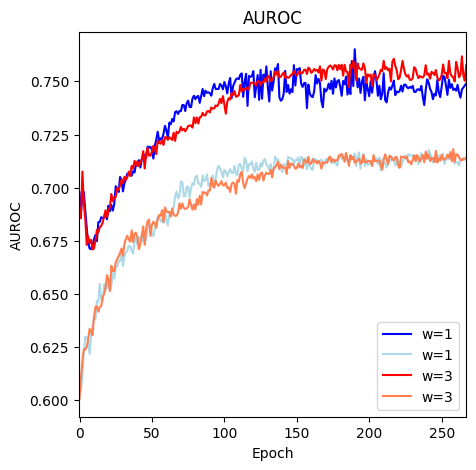

In [32]:
## Compare two runs to compare width of projection network (everything else is fixed)
x = 'SIMCLR-1041609'
x_label = 'w=1'


y= 'SIMCLR-1041874' 
y_label = 'w=3'

compare_two_runs(master, x, y, x_label, y_label)


## 3.b Fix batch size 
These two runs cannot be directly compared because we did not change the learning rate. In fact we should maximize the batch size and use multiple GPUs. Based on those results, we can conclude that with a bigger batch size, we are slower (less number of epochs) but were able to get better results. 

              run  epoch  train_auroc  train_auprc  val_auroc  val_auprc  \
1  SIMCLR-1041609  241.0       0.7495     0.448727   0.717742   0.407997   

   test_auroc  test_auprc  
1    0.707609    0.399673  
              run  epoch  train_auroc  train_auprc  val_auroc  val_auprc  \
2  SIMCLR-1041613  188.0      0.76372     0.471773    0.72139   0.411226   

   test_auroc  test_auprc  
2    0.716073    0.407952  


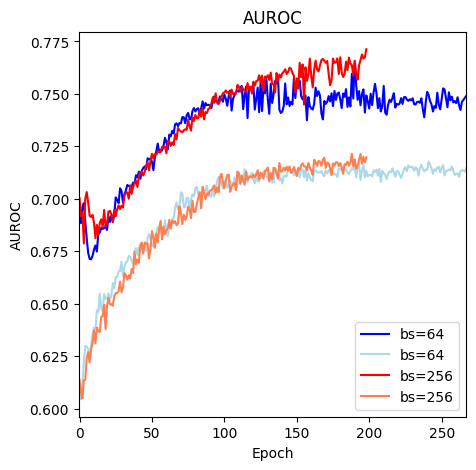

In [46]:
x = 'SIMCLR-1041609'
x_label = 'bs=64'
# Each epoch takes around 22 minutes, 267 checkpoints --> 89 hours

y= 'SIMCLR-1041613' 
y_label = 'bs=256'
# Each epoch takes around 28 minutes, 189 epochs --> 89 hours

compare_two_runs(master, x, y, x_label, y_label)

print(best_results.loc[(best_results.run==x)])
print(best_results.loc[(best_results.run==y)])

## 3.b Single vs 4 GPUs
It seems that I need to adjust the learning rate.

              run  epoch  train_auroc  train_auprc  val_auroc  val_auprc  \
6  SIMCLR-1043817  299.0     0.735807     0.434693   0.671061   0.361913   

   test_auroc  test_auprc  
6    0.663959    0.357918  
              run  epoch  train_auroc  train_auprc  val_auroc  val_auprc  \
2  SIMCLR-1041613  188.0      0.76372     0.471773    0.72139   0.411226   

   test_auroc  test_auprc  
2    0.716073    0.407952  


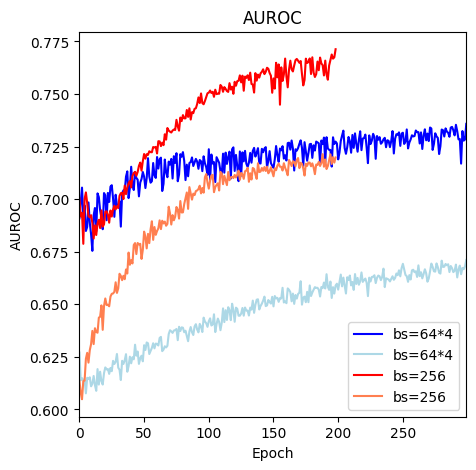

In [47]:
x = 'SIMCLR-1043817'
x_label = 'bs=64*4'
# Effective batch size is 256
# Each epoch takes around 14 minutes, 299 epochs --> 69 hours (reached max num of epochs)
# Question is: does pytorch lightning divide the learning rate with parallel computing?

y= 'SIMCLR-1041613' 
y_label = 'bs=256'
# Each epoch takes around 28 minutes, 189 epochs --> 89 hours

compare_two_runs(master, x, y, x_label, y_label)

print(best_results.loc[(best_results.run==x)])
print(best_results.loc[(best_results.run==y)])

## 3.c Large vs small dataset

              run  epoch  train_auroc  train_auprc  val_auroc  val_auprc  \
3  SIMCLR-1041612   12.0     0.745107     0.447913   0.708421   0.404306   

   test_auroc  test_auprc  
3    0.709636    0.405438  
              run  epoch  train_auroc  train_auprc  val_auroc  val_auprc  \
2  SIMCLR-1041613  188.0      0.76372     0.471773    0.72139   0.411226   

   test_auroc  test_auprc  
2    0.716073    0.407952  


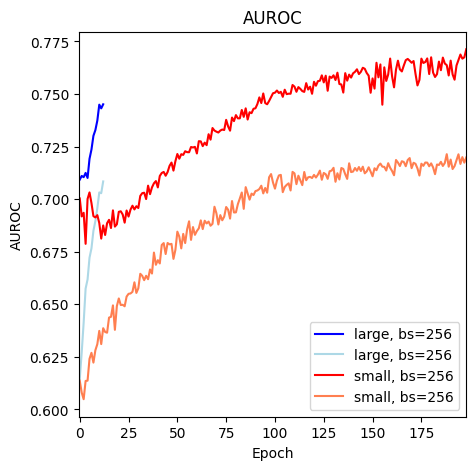

In [50]:
x = 'SIMCLR-1041612'
x_label = 'large, bs=256'
# The training set has 1.5 million
# Each epoch takes around 12 hours, 13 epochs --> 156 hours

y= 'SIMCLR-1041613' 
y_label = 'small, bs=256'
# Each epoch takes around 28 minutes, 189 epochs --> 89 hours


compare_two_runs(master, x, y, x_label, y_label)

print(best_results.loc[(best_results.run==x)])
print(best_results.loc[(best_results.run==y)])

To optimize all runs we could:

    - turn off validation after each epoch
    - turn off recording into neptune the train loss etc.
    - 

### Best model

(-0.5, 20.0)

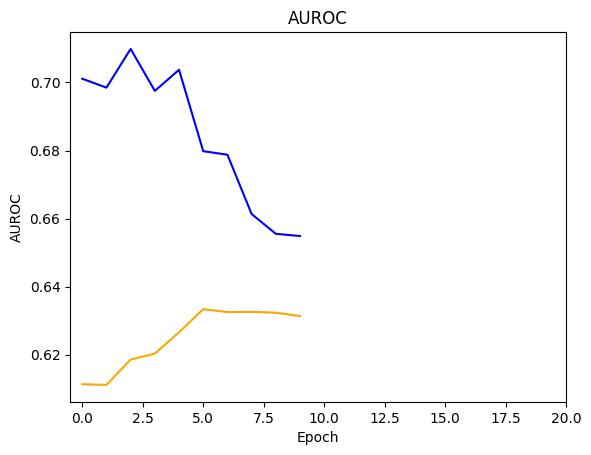

In [26]:
# AUROC and AUPRC across epochs
x = 'T-SIMCLR-1042373'
#selected_model.run

plot(master[x].epoch.values, master[x].train_auroc.values, color='b', label='train_auroc')
plot(master[x].epoch.values, master[x].val_auroc.values, color='orange', label='val_auroc')

plt.ylabel('AUROC')
plt.xlabel('Epoch')
plt.title('AUROC')
plt.xlim([-0.5,20])

In [58]:
x= True
fusion_type='None'
if ((fusion_type=='None') & (x == True)):
    print('execute')

execute
